# Introduction

In this notebook, we'll perform basic aggregation, imputation, model building, and profit margin attribution for the retail sales data located in "retail_sales_data.csv". 

Fortunately, this dataset has been given to us clean and we'll only be performing some feature engineering rather than raw data cleaning. 

There will be 3 parts to our analysis:
1. Aggregation and plotting. 
2. Rental cost data imputation.
3. Profit margin attribution. 

Let's jump into it!

In [444]:
# Import relevant libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Could've imported plotly, but it's overkill for our basic plotting needs

In [445]:
# Define utility functions
identity = lambda x: x[0]

In [446]:
# Import dataset from CSV
data = pd.read_csv("retail_sales_data.csv")

# Section 1

Profit Margin Calculation:

"The profit margin formula is net income divided by net sales. Net sales is gross sales minus discounts, returns, and allowances. Net income is total revenue minus expenses. A 10% margin is considered average."

Source: https://www.fundera.com/blog/profit-margins#:~:text=The%20profit%20margin%20formula%20is,10%25%20margin%20is%20considered%20average.

In our dataset:

$Net\ income = Gross\ revenue - Fixed\ cost - Variable\ cost - Rental\ cost$

$Net\ sales = Gross\ revenue$

Note: By looking at the dataframe, we can see that the number of products sold by a location does not change month-over-month.

In [447]:
# Calculating Profit Margin...
data["Net income"] = data["Gross revenue"] - (data["Fixed cost"] + data["Variable cost"] + data["Rental cost"])
# Rounded profit margin so it's easier to read
data["Profit Margin %"] = ((data["Net income"]/data["Gross revenue"]) * 100).round(2)

In [448]:
data.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Net income,Profit Margin %
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False,14765945.10,30.37
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False,12036707.48,25.02
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False,20089024.69,31.22
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False,12775913.49,27.81
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False,7941319.37,24.24


In [449]:
# Grouping data for each location to get annual revenue and cost information
annual_data = data.groupby("Location number").agg({
    "State": identity, 
    "Gross revenue": np.sum,
    "Fixed cost": np.sum,
    "Variable cost": np.sum,
    "Rental cost": np.sum,
    "Number of products": identity,
    "Owned": identity,
    "Net income": np.sum
})
# Recalculating Profit Margin % (otherwise would need to take a weighted average of Profit Margin %'s)
annual_data["Net income"] = annual_data["Gross revenue"] - (annual_data["Fixed cost"] + annual_data["Variable cost"] + annual_data["Rental cost"])
# Rounded profit margin so it's easier to read
annual_data["Profit Margin %"] = ((annual_data["Net income"]/annual_data["Gross revenue"]) * 100).round(3)

In [450]:
pm_mean = annual_data["Profit Margin %"].mean().round(3)
pm_median = annual_data["Profit Margin %"].median().round(3)

print("The mean annual profit margin of a typical store is " + str(pm_mean) + "%")
print("The median annual profit margin of a typical store is " + str(pm_median) + "%")

The mean annual profit margin of a typical store is 24.863%
The median annual profit margin of a typical store is 26.185%


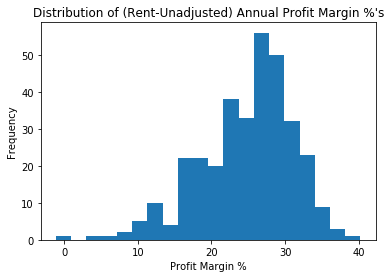

In [451]:
ax = annual_data["Profit Margin %"].plot.hist(bins=20)
ax.set_title("Distribution of (Rent-Unadjusted) Annual Profit Margin %'s")
ax.set_xlabel("Profit Margin %");

In [452]:
# Grouping data by month to get aggregate monthly revenue and cost information (ignoring irrelevant columns)
monthly_data = data.groupby("Month").agg({
    "Gross revenue": np.sum,
    "Fixed cost": np.sum,
    "Variable cost": np.sum,
    "Rental cost": np.sum,
    "Number of products": identity,
    "Net income": np.sum
})
monthly_data["Net income"] = monthly_data["Gross revenue"] - (monthly_data["Fixed cost"] + monthly_data["Variable cost"] + monthly_data["Rental cost"])
monthly_data["Profit Margin %"] = ((monthly_data["Net income"]/monthly_data["Gross revenue"]) * 100).round(3)

In [453]:
monthly_data.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Net income,Profit Margin %
Month,,,,,,,
1,9.304129e+09,2.069499e+09,4.943004e+09,49191170,4452,2.242435e+09,24.102
2,9.786843e+09,1.964354e+09,5.180280e+09,49191170,4452,2.593018e+09,26.495
3,1.158736e+10,2.296857e+09,6.126065e+09,49191170,4452,3.115249e+09,26.885
4,9.105208e+09,1.915483e+09,4.754642e+09,49191170,4452,2.385892e+09,26.204
5,9.347461e+09,1.877253e+09,4.860179e+09,49191170,4452,2.560839e+09,27.396


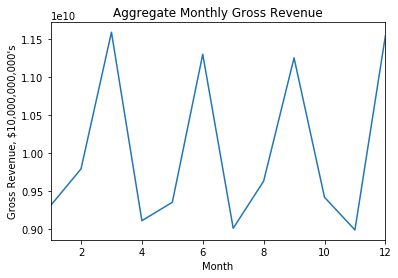

In [454]:
ax = monthly_data["Gross revenue"].plot.line()
ax.set_title("Aggregate Monthly Gross Revenue")
ax.set_ylabel("Gross Revenue, $10,000,000,000's");
# We can see a very obvious cyclical trend here

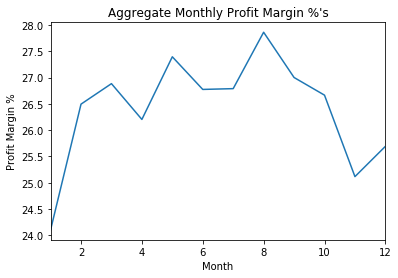

In [455]:
ax = monthly_data["Profit Margin %"].plot.line()
ax.set_title("Aggregate Monthly Profit Margin %'s")
ax.set_ylabel("Profit Margin %");

In [456]:
# Grouping data by quarter to get aggregate quarterly revenue and cost information (ignoring irrelevant columns)
# Here, I'm assuming the company's fiscal quarters follow the calendar year
qtrly_data = monthly_data.copy()
qtrly_data["Quarter"] = ((qtrly_data.index-0.33)//3).astype(int)
qtrly_data = qtrly_data.groupby("Quarter").agg({
    "Gross revenue": np.sum,
    "Fixed cost": np.sum,
    "Variable cost": np.sum,
    "Rental cost": np.sum,
    "Net income": np.sum
})
qtrly_data["Net income"] = qtrly_data["Gross revenue"] - (qtrly_data["Fixed cost"] + qtrly_data["Variable cost"] + qtrly_data["Rental cost"])
qtrly_data["Profit Margin %"] = ((qtrly_data["Net income"]/qtrly_data["Gross revenue"]) * 100).round(3)

In [457]:
qtrly_data.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Net income,Profit Margin %
Quarter,,,,,,
0,3.067833e+10,6.330709e+09,1.624935e+10,147573510,7.950702e+09,25.916
1,2.975031e+10,6.168927e+09,1.546212e+10,147573510,7.971688e+09,26.795
2,2.988107e+10,6.241126e+09,1.536014e+10,147573510,8.132233e+09,27.215
3,2.993717e+10,6.227698e+09,1.583052e+10,147573510,7.731375e+09,25.825


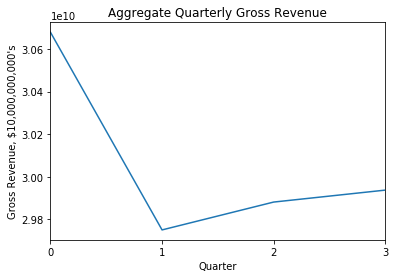

In [458]:
ax = qtrly_data["Gross revenue"].plot.line(xticks=[0,1,2,3])
ax.set_title("Aggregate Quarterly Gross Revenue")
ax.set_ylabel("Gross Revenue, $10,000,000,000's");

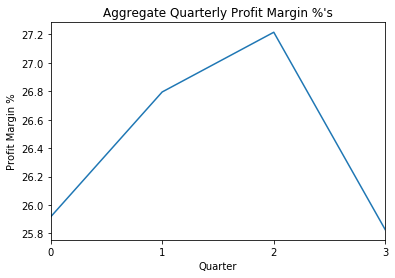

In [459]:
ax = qtrly_data["Profit Margin %"].plot.line(xticks=[0,1,2,3])
ax.set_title("Aggregate Quarterly Profit Margin %'s")
ax.set_ylabel("Profit Margin %");

# Section 2

To impute a rental cost for owned locations, initially I wanted to find the average of all rental costs for unowned stores in that state. However, many states only had owned stores, so I decided to use a few input variables (intentionally ignoring the linearly dependent ones) to train an OLS linear regression model for predicted rental cost. 

Eventually, I could further perform PCA & look at $R^2$ and model coefficient values to understand the impact each input has on the predicted $Rental\ cost$.

In [460]:
locations_with_rental_cost = annual_data.copy()[annual_data["Rental cost"] != 0]
locations_without_rental_cost = annual_data.copy()[annual_data["Rental cost"] == 0]
X_train, X_test, y_train, y_test = train_test_split(
    locations_with_rental_cost[["Gross revenue", "Fixed cost", "Variable cost", "Number of products"]], 
    locations_with_rental_cost[["Rental cost"]], test_size=0.25, random_state=42)
# Normalization won't make a difference for OLS
model = LinearRegression()
model.fit(X_train, y_train)
print("R^2 for training data: " + str(model.score(X_train, y_train)))
print("R^2 for testing data: " + str(model.score(X_test, y_test)))

R^2 for training data: 0.5396942401579674
R^2 for testing data: 0.6676915936799361


In [461]:
model.coef_

array([[ 1.43069570e-02,  1.31116381e-02, -1.98944475e-02,
        -4.51405088e+03]])

In [462]:
predicted_rents = model.predict(locations_without_rental_cost[["Gross revenue", "Fixed cost", "Variable cost", "Number of products"]])
locations_without_rental_cost["Rental cost"] = predicted_rents
rent_adjusted_annual_data = locations_without_rental_cost.append(locations_with_rental_cost).sort_index()
rent_adjusted_annual_data["Net income"] = rent_adjusted_annual_data["Gross revenue"] - (rent_adjusted_annual_data["Fixed cost"] + rent_adjusted_annual_data["Variable cost"] + rent_adjusted_annual_data["Rental cost"])
rent_adjusted_annual_data["Profit Margin %"] = ((rent_adjusted_annual_data["Net income"]/rent_adjusted_annual_data["Gross revenue"]) * 100).round(3)
rent_adjusted_annual_data["Location number"] = rent_adjusted_annual_data.index
rent_adjusted_annual_data.head()

,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Net income,Profit Margin %,Location number
Location number,,,,,,,,,,
1,TX,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06,4452,False,1.500840e+08,27.552,1
2,TX,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05,4502,False,8.858672e+07,24.886,2
3,IL,3.317718e+08,6.429775e+07,1.848279e+08,1.040352e+06,4620,True,8.160583e+07,24.597,3
4,GA,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06,4481,False,5.494349e+07,20.813,4
5,NJ,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05,4533,False,3.960178e+07,20.953,5


In [463]:
ra_pm_mean = rent_adjusted_annual_data["Profit Margin %"].mean().round(3)
ra_pm_median = rent_adjusted_annual_data["Profit Margin %"].median().round(3)

print("The rent-adjusted mean annual profit margin of a typical store is " + str(ra_pm_mean) + "%")
print("The rent-adjusted median annual profit margin of a typical store is " + str(ra_pm_median) + "%")

The rent-adjusted mean annual profit margin of a typical store is 24.82%
The rent-adjusted median annual profit margin of a typical store is 26.116%


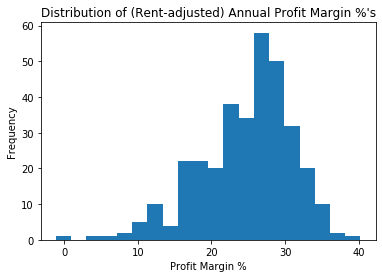

In [464]:
ax = rent_adjusted_annual_data["Profit Margin %"].plot.hist(bins=20)
ax.set_title("Distribution of (Rent-adjusted) Annual Profit Margin %'s")
ax.set_xlabel("Profit Margin %");

# Section 3

The CEO's main focus is on maximizing profit margin by location.

We began by adding in cost of living data by state (source: https://www.patriotsoftware.com/blog/accounting/average-cost-living-by-state/), focusing on the $Value\ of\ a\ Dollar$ attribute because it indicates consumer buying power in that state. Under the assumption that we're selling a similar range of products in each store, the customer buying power might help us understand the profit margin in a state. We could also have looked at the $Annual\ Mean\ Wage$ attribute.

We used the $rent_adjusted_annual_data$ for all following analysis because that accounts for amortized payments for owned locations even if we do decide to own a new location. 

I considered incorporating the $Median\ Monthly\ Rent$ to the model above, but did not because I'm not sure whether the sample data we're analyzing is contrived or real data. 

In [465]:
state_abbreviation_data = pd.read_csv("state_abbreviations.csv")
state_abbreviation_data.head()

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [466]:
col_data = pd.read_csv("cost_of_living_data.csv")
col_data = col_data.merge(state_abbreviation_data, how="inner", on="State")
col_data.head()

,State,Annual Mean Wage (All Occupations),Median Monthly Rent,Value of a Dollar,Abbrev,Code
0,Alabama,"$43,790",$998,$1.15,Ala.,AL
1,Alaska,"$58,710","$1,748",$0.95,Alaska,AK
2,Arizona,"$49,290","$1,356",$1.04,Ariz.,AZ
3,Arkansas,"$41,540",$953,$1.15,Ark.,AR
4,California,"$59,150","$2,518",$0.87,Calif.,CA


In [467]:
rent_adjusted_annual_data = rent_adjusted_annual_data.merge(col_data, how="left", left_on="State", right_on="Code")

In [491]:
# Let's try seeing which factors correlate well with Profit Margin % before plotting - Number of products seems to the most
corrs = rent_adjusted_annual_data[["Gross revenue", "Fixed cost", "Variable cost", "Rental cost", "Number of products", "Profit Margin %"]]
corrs = corrs.corr(method='pearson')
corrs.style.apply(lambda x: ["background: lightgreen" if v > 0.75 and v < 1 else "" for v in x], axis = 1)

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Profit Margin %
Gross revenue,1,0.960217,0.991511,0.6724,0.476531,0.480719
Fixed cost,0.960217,1,0.965371,0.709039,0.337006,0.307661
Variable cost,0.991511,0.965371,1,0.671034,0.427667,0.395491
Rental cost,0.6724,0.709039,0.671034,1,-0.0170491,0.188269
Number of products,0.476531,0.337006,0.427667,-0.0170491,1,0.804154
Profit Margin %,0.480719,0.307661,0.395491,0.188269,0.804154,1


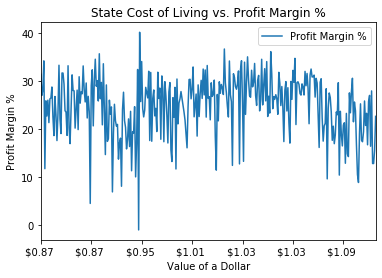

In [468]:
ax = rent_adjusted_annual_data.sort_values("Value of a Dollar").plot.line("Value of a Dollar", "Profit Margin %")
ax.set_title("State Cost of Living vs. Profit Margin %")
ax.set_ylabel("Profit Margin %");
# There doesn't seem to be an obvious trend here.

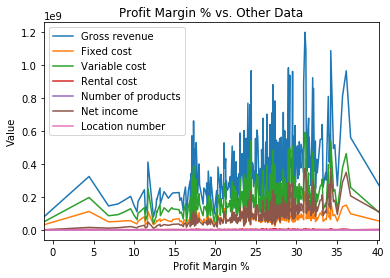

In [479]:
ax = rent_adjusted_annual_data.sort_values("Profit Margin %").plot.line("Profit Margin %")
ax.set_title("Profit Margin % vs. Other Data")
ax.set_ylabel("Value");
# Using line plot so we can graph multiple values together
# We can see a very clear upward trend with each of the revenue and cost numbers as profit margin # increases
# Some of these are linearly dependent, but it's still great to see

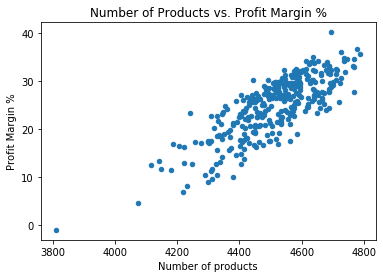

In [480]:
ax = rent_adjusted_annual_data.sort_values("Number of products").plot.scatter("Number of products", "Profit Margin %")
ax.set_title("Number of Products vs. Profit Margin %")
ax.set_ylabel("Profit Margin %");
# Very clear upward trend visible here!

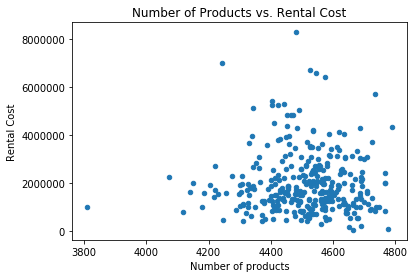

In [476]:
ax = rent_adjusted_annual_data.sort_values("Number of products").plot.scatter("Number of products", "Rental cost")
ax.set_title("Number of Products vs. Rental Cost")
ax.set_ylabel("Rental Cost");
# Wanted to see whether a higher product assortment implied higher rental costs (possibly due to a bigger floorspace)
# There doesn't seem to be an obvious trend

# Conclusion

We've found some great trends through our analysis, and there seems to be a strong correlation between the assortment of products sold at a location and its profit margin %. Our findings will be summarized in $email.txt$.

### Further Analysis
- Perform PCA and other analyses on contributors to rent costs, thus creating a better model
- Breakdown sales by creating a more detailed data ingestion ETL pipeline, so we can understand margins of individual products
- Analyze whether the key factor causing difference in profit margin is the location itself, sales volume, and related factors (like buying power of local customers, accessibility of location, etc.) or whether it's which products are being sold there (say, for example, we sell more beach towels in Florida than Oklahoma, and beach towels happen to have a very high profit margin).